#### Technical setup
> Skip this section

In [108]:
# @formatter:off

In [109]:
%%time
%reload_ext autoreload
%autoreload 2
# @formatter:on

CPU times: user 4.73 ms, sys: 8.08 ms, total: 12.8 ms
Wall time: 13.5 ms


# Setup

In [110]:
symbol = 'ETHUSDT'
symbol_k_lines_interval = '1s'
symbol_ask_bid_price_difference = 0.01
price_step_ratio = 0.001

# Ticks

In [111]:
from binance.binance_k_line_loader import load_binance_k_lines
from binance.binance_tick_loader import load_binance_ticks
from chart.ttm_chart import draw_line_chart

k_lines = load_binance_k_lines(f"../../../ttm-data/{symbol}-{symbol_k_lines_interval}-*.csv")

ticks = load_binance_ticks(k_lines, symbol_ask_bid_price_difference)

# draw_line_chart(ticks.timestamp, ticks.bid_price, name='Bid Price')
ticks

,timestamp,bid_price,ask_price
0,1677628800000,1605.24,1605.25
1,1677628801000,1605.46,1605.47
2,1677628802000,1605.46,1605.47
3,1677628803000,1605.46,1605.47
4,1677628804000,1605.47,1605.48
...,...,...,...
86395,1681775995000,2074.00,2074.01
86396,1681775996000,2074.00,2074.01
86397,1681775997000,2074.00,2074.01
86398,1681775998000,2074.00,2074.01


# Simulation

In [112]:
%%time

from trade.trade_simulator import TradeSimulator

trade_simulator: TradeSimulator = TradeSimulator()
trade_simulator.process_ticks(ticks, price_step_ratio)

CPU times: user 55.3 s, sys: 552 ms, total: 55.8 s
Wall time: 56 s


# Results


Closed orders count: 30048
Cumulative profit: -1199.4400000001137


/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/src/chart/ttm_chart.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=60)


,open_timestamp,type,open_price,close_price,close_timestamp,profit,cumulative_profit
0,1.677629e+12,BUY,1603.36,1601.48,1.677629e+12,-1.88,-1.88
1,1.677629e+12,BUY,1601.49,1603.28,1.677630e+12,1.79,-0.09
2,1.677630e+12,SELL,1603.28,1605.15,1.677630e+12,-1.87,-1.96
3,1.677630e+12,SELL,1605.14,1606.81,1.677630e+12,-1.67,-3.63
4,1.677630e+12,SELL,1606.80,1608.50,1.677630e+12,-1.70,-5.33
...,...,...,...,...,...,...,...
30043,1.681771e+12,BUY,2080.85,2078.74,1.681772e+12,-2.11,-1198.95
30044,1.681772e+12,BUY,2078.75,2076.38,1.681773e+12,-2.37,-1201.32
30045,1.681773e+12,BUY,2076.39,2073.92,1.681774e+12,-2.47,-1203.79
30046,1.681774e+12,BUY,2073.93,2076.20,1.681775e+12,2.27,-1201.52


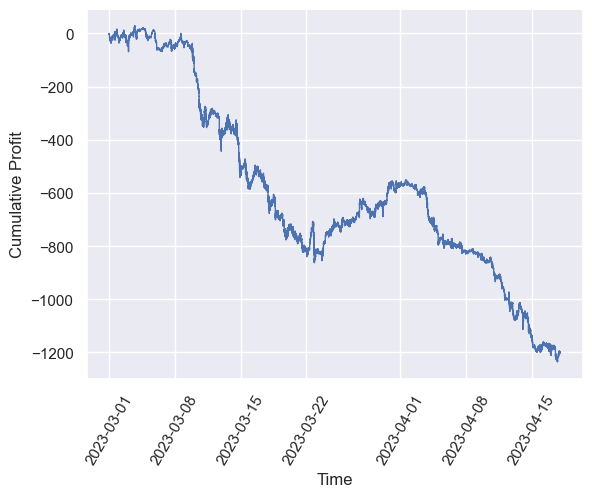

In [113]:
profits = trade_simulator.get_profits()

print(f"=========")
print(f"Closed orders count: {len(trade_simulator.closed_orders)}")
print(f"Cumulative profit: {trade_simulator.get_cumulative_profit()}")
print(f"=========")
draw_line_chart(profits.open_timestamp, profits.cumulative_profit, name='Cumulative Profit')

# -1199.4400000001137
profits